In [18]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
import scikit_posthocs as sp

In [19]:
plt.rcParams.update({'figure.facecolor': 'white'})
sns.set_style('whitegrid')

def load_summaries(csv_dirs):
    df_list = []
    for alg, pattern in csv_dirs.items():
        for fp in glob.glob(pattern):
            df = pd.read_csv(fp)
            df['algorithm'] = alg
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

def load_histories(csv_dirs_hist):
    df_list = []
    for alg, pattern in csv_dirs_hist.items():
        for fp in glob.glob(pattern):
            df = pd.read_csv(fp)
            df['algorithm'] = alg
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

csv_dirs = {
    'CMA_ES': 'CMA_ES_results_20250527_125054/CMA_ES_results.csv',
    'DE':     'DE_VariableDimensions_results_20250527_125928/DE_results.csv',
    'GA':     'GA_Variable_results_20250527_131116/GA_Variable_results.csv',
    'GE':     'GE_results_20250527_200128/GE_results.csv',
    'GP':     'GP_results_20250527_132707/GP_results.csv',
}

csv_dirs_hist = {
    'CMA_ES': 'CMA_ES_results_20250527_125054/CMA_ES_history.csv',
    'DE':     'DE_VariableDimensions_results_20250527_125928/DE_history.csv',
    'GA':     'GA_Variable_results_20250527_131116/GA_Variable_history.csv',
    'GE':     'GE_results_20250527_200128/GE_history.csv',
    'GP':     'GP_results_20250527_132707/GP_history.csv',
}

results = load_summaries(csv_dirs)
history = load_histories(csv_dirs_hist)

print(results.describe())
print(results.isna().sum())
results = results[np.isfinite(results['best'])]

target_map = {
    'Sphere':30,
    'Rastrigin':30,
    'Griewank':30,
    'Ackley':30,
    'Koza':10,
    'Knapsack':20,
    'Parity':64,
    'SantaFe':100
}

results = results[np.isfinite(results['best'])]
results['delta_len'] = results.apply(
    lambda r: abs(r['len_final'] - target_map[r['benchmark']]), axis=1
)

        replicate          seed        best   len_final        cpu_s
count  900.000000  9.000000e+02  900.000000  900.000000   900.000000
mean    14.500000  1.082326e+09  -50.852204   55.256667   346.766766
std      8.660254  6.258997e+08  156.731791   67.053195   965.833336
min      0.000000  6.106058e+06 -569.000000    3.000000     1.837900
25%      7.000000  5.462523e+08   -2.825000   27.750000    10.881225
50%     14.500000  1.093769e+09    0.004209   32.000000    29.165400
75%     22.000000  1.603804e+09    1.140622   66.000000   240.585800
max     29.000000  2.146668e+09   95.868915  568.000000  6725.203700
run_id       0
benchmark    0
replicate    0
seed         0
best         0
len_final    0
cpu_s        0
algorithm    0
dtype: int64


                         best_q      best_q     best_q      best_q  \
benchmark algorithm                                                  
Ackley    CMA_ES       3.021107    0.000024  16.427833    0.000001   
          DE           0.093461    0.067923   0.082394    0.046240   
          GA           0.094488    0.085276   0.043781    0.058997   
Griewank  CMA_ES       4.334268    0.000000  16.543014    0.000000   
          DE           0.001875    0.000443   0.003328    0.000195   
          GA           0.000745    0.000543   0.000662    0.000306   
Knapsack  CMA_ES    -472.100000 -473.000000  40.156891 -495.000000   
          DE        -508.000000 -508.000000   0.000000 -508.000000   
          GA        -569.000000 -569.000000   0.000000 -569.000000   
Koza      CMA_ES       8.402886    0.006428  21.814957    0.002607   
          DE           4.189637    1.848936   7.009087    1.140622   
          GA           0.032965    0.024597   0.026798    0.016475   
          GE        

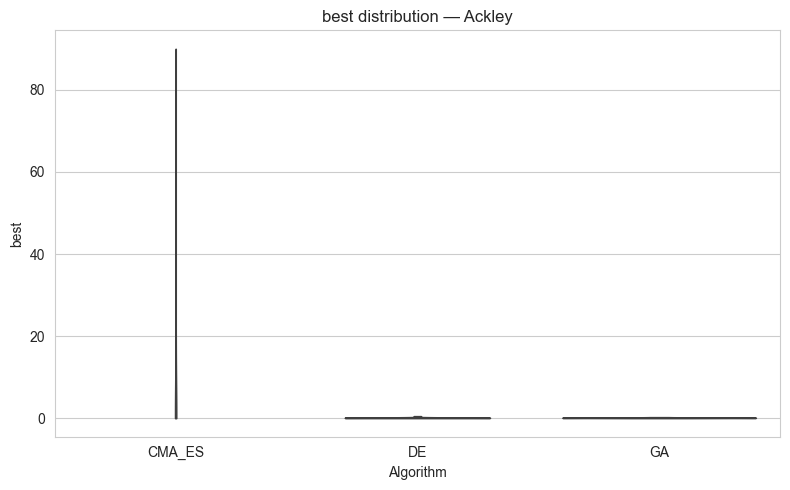

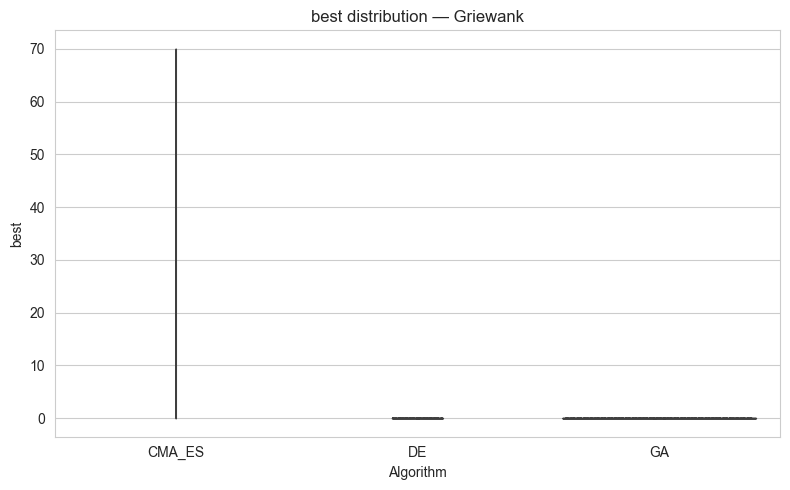

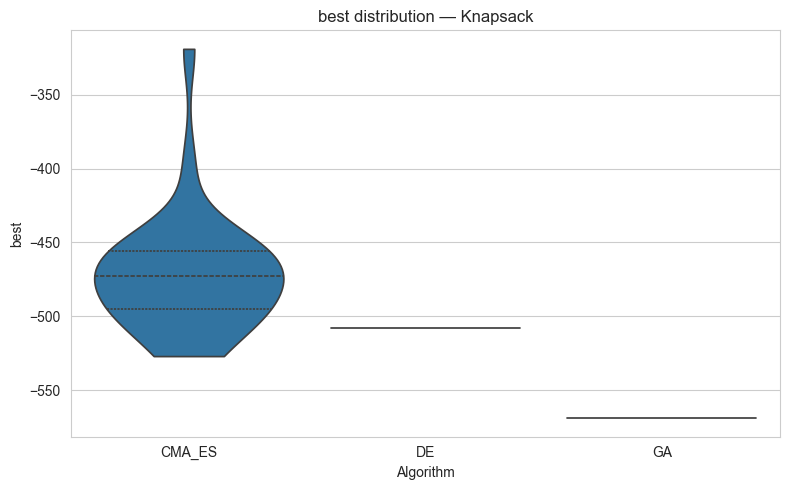

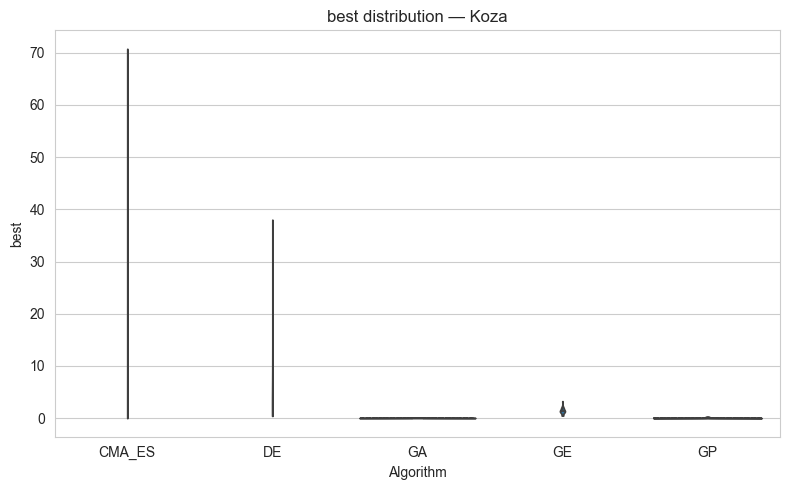

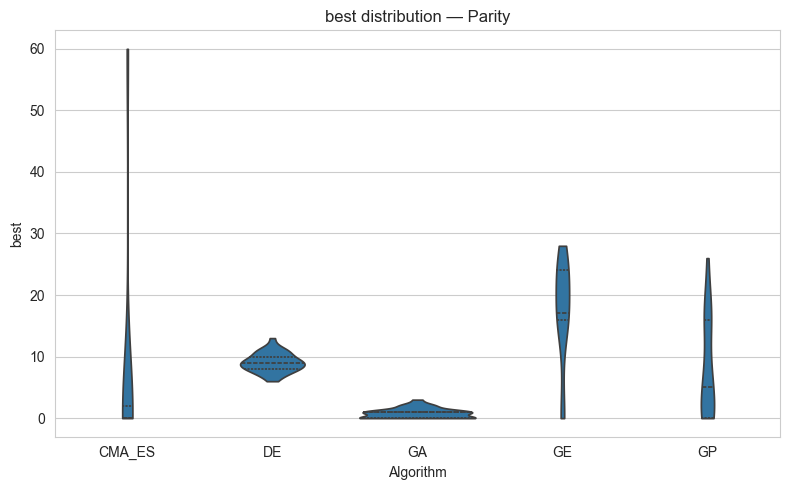

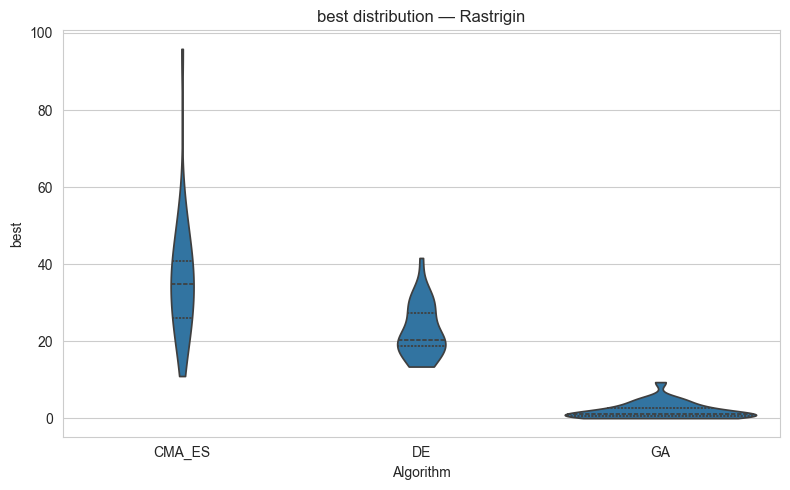

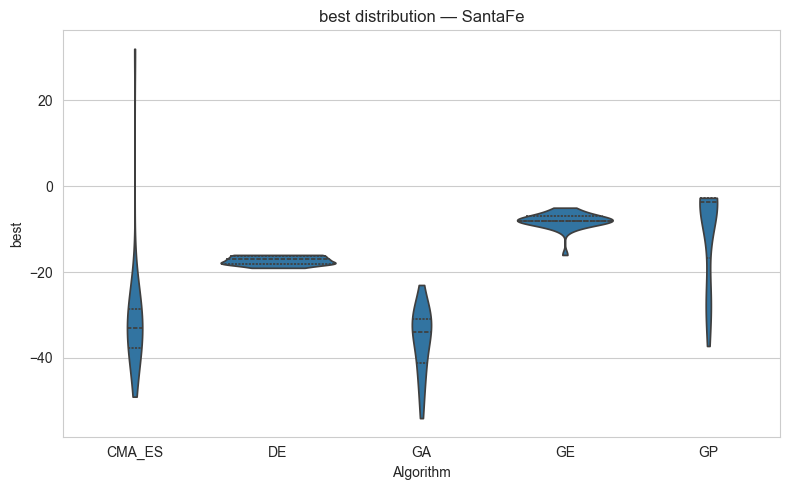

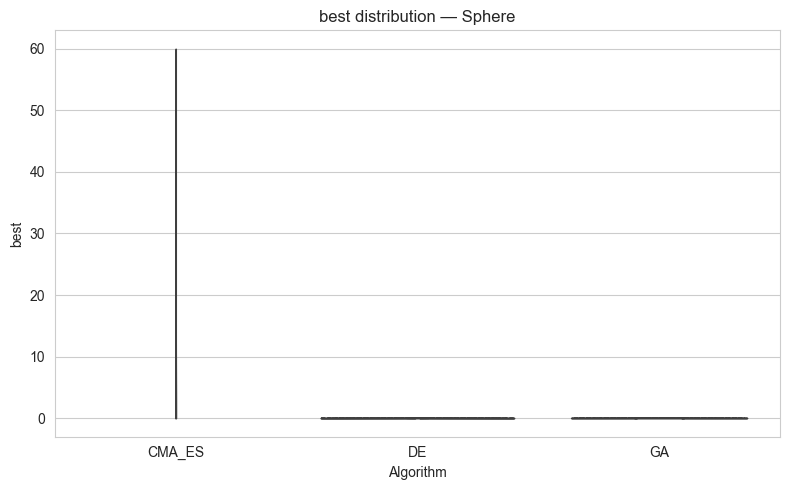

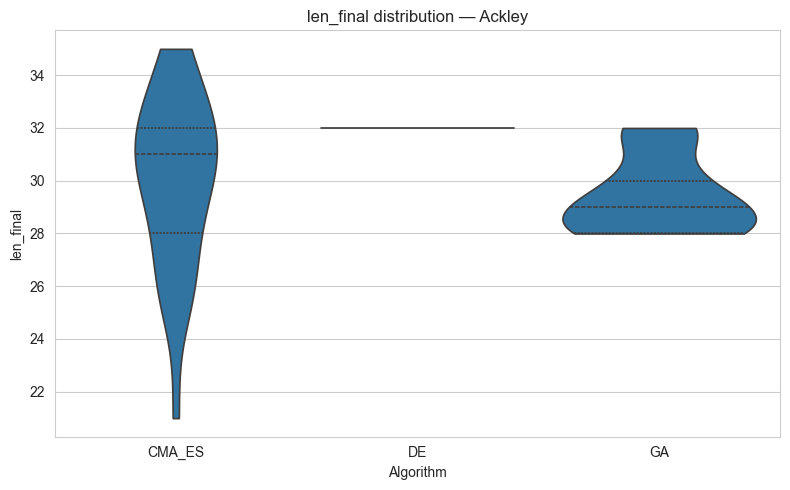

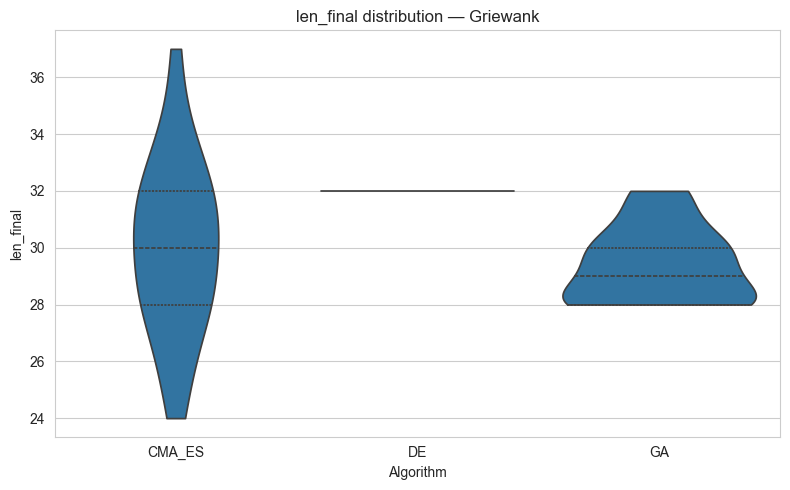

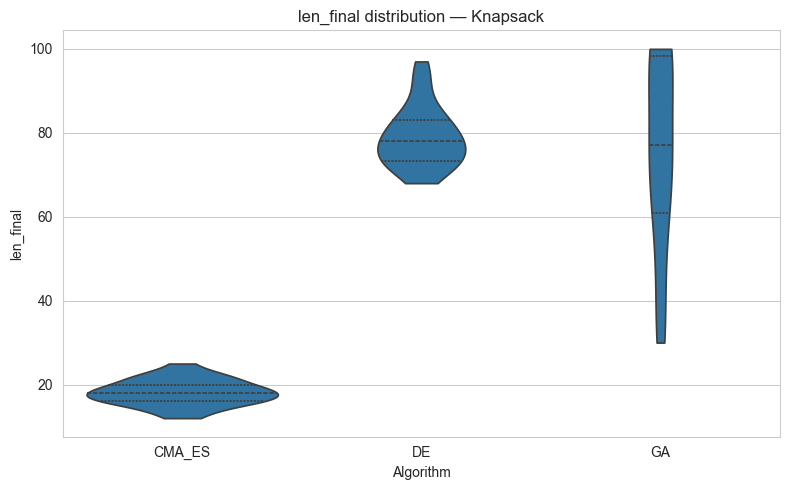

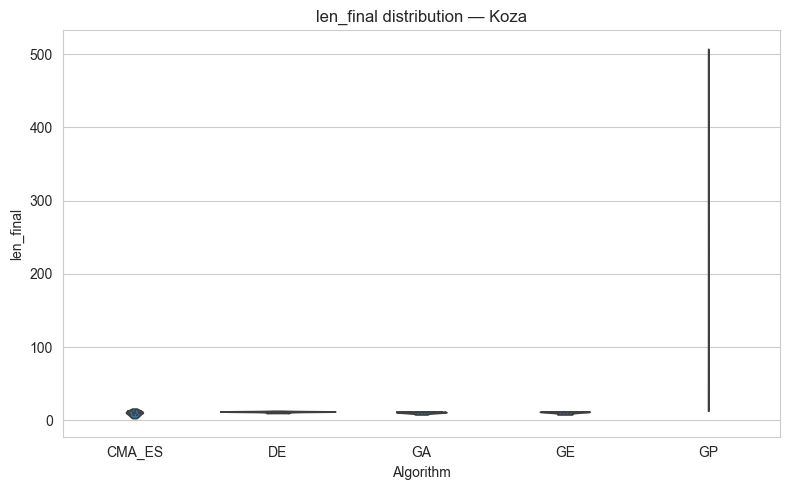

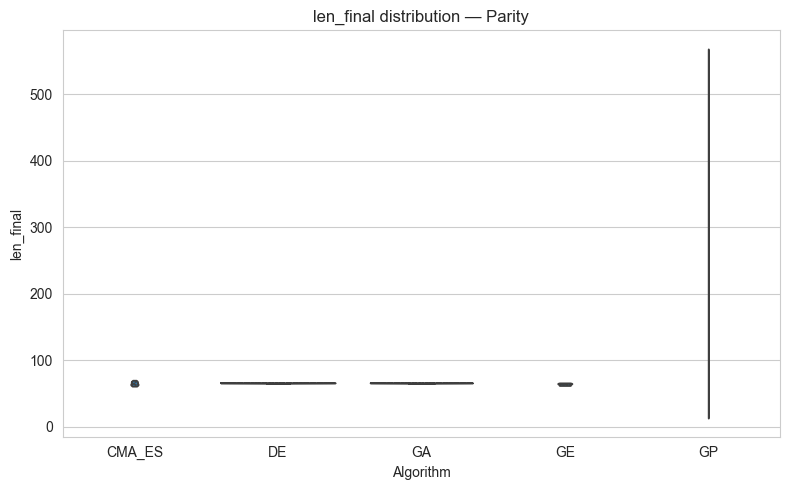

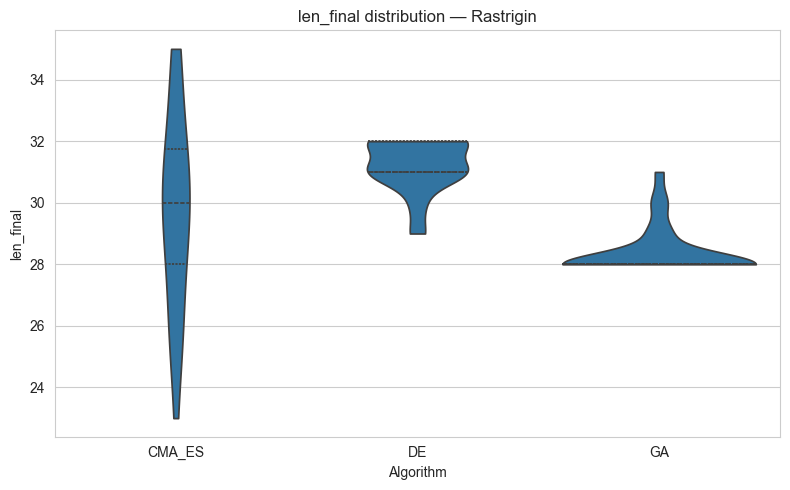

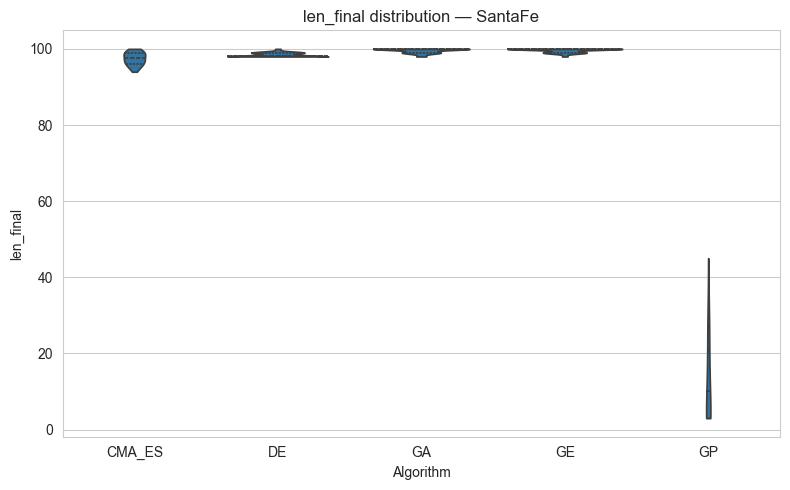

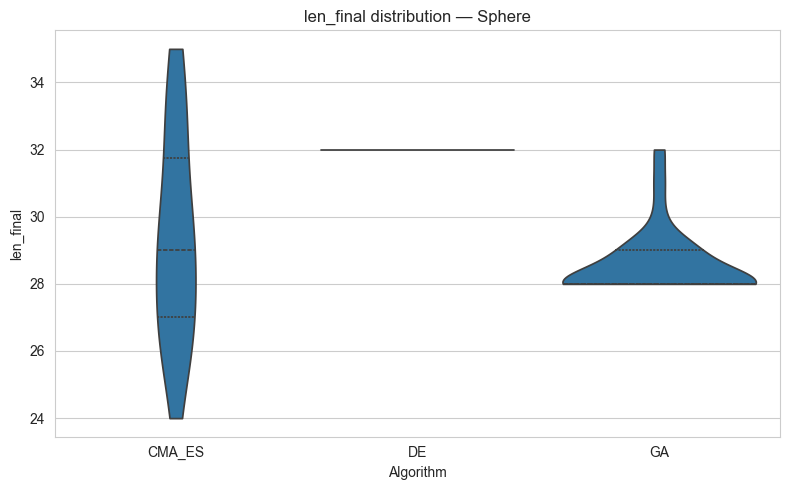

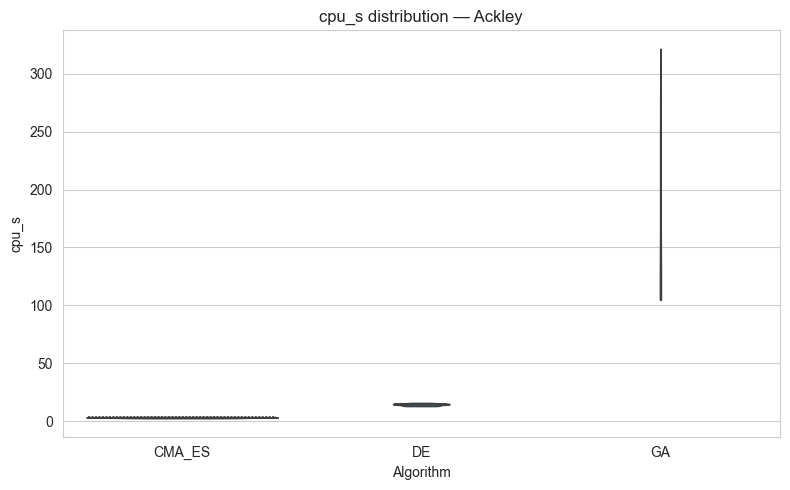

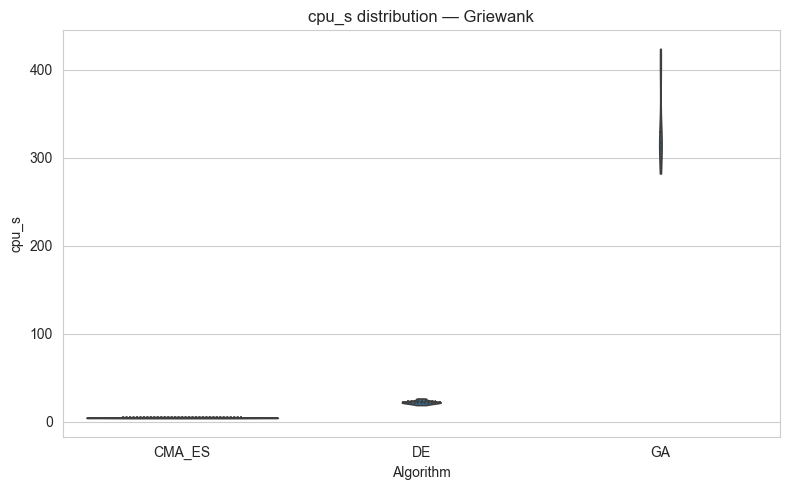

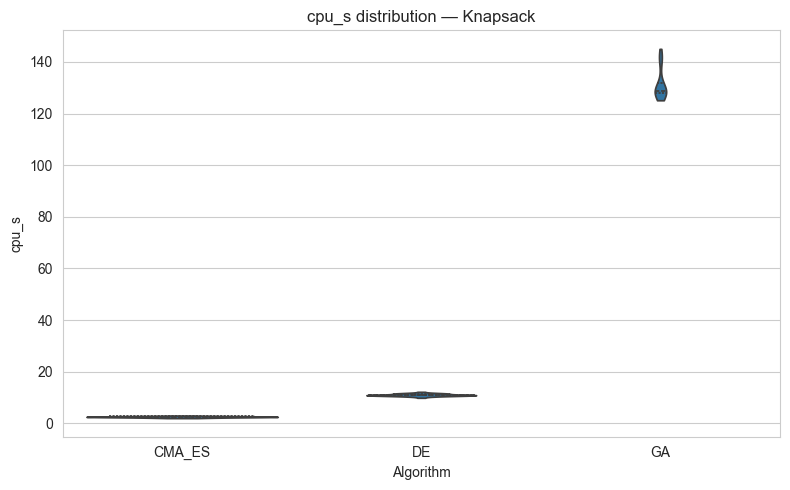

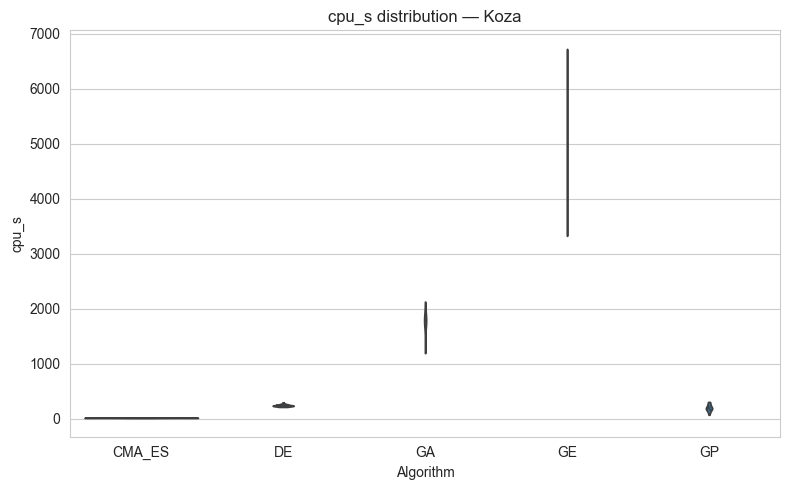

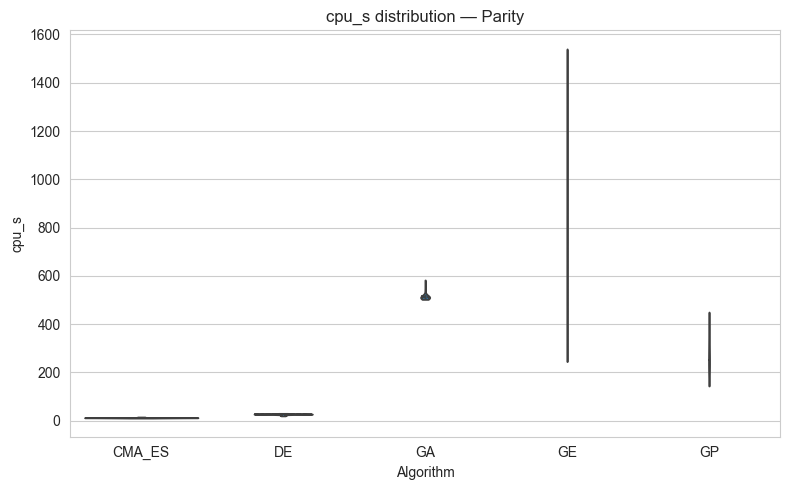

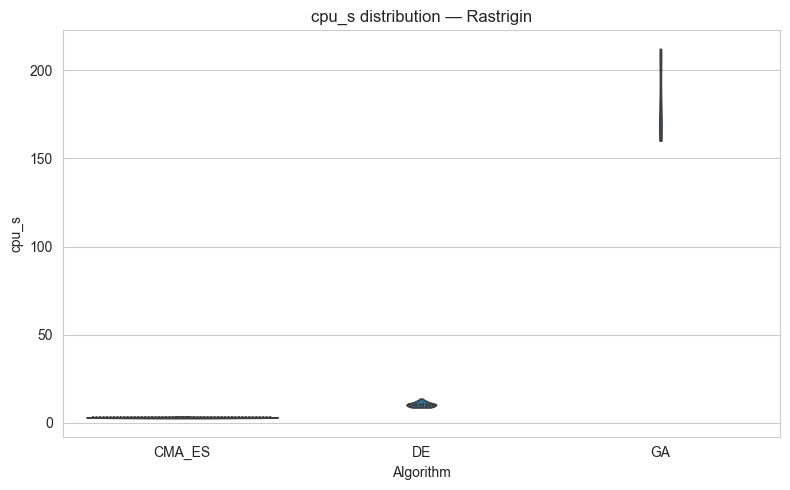

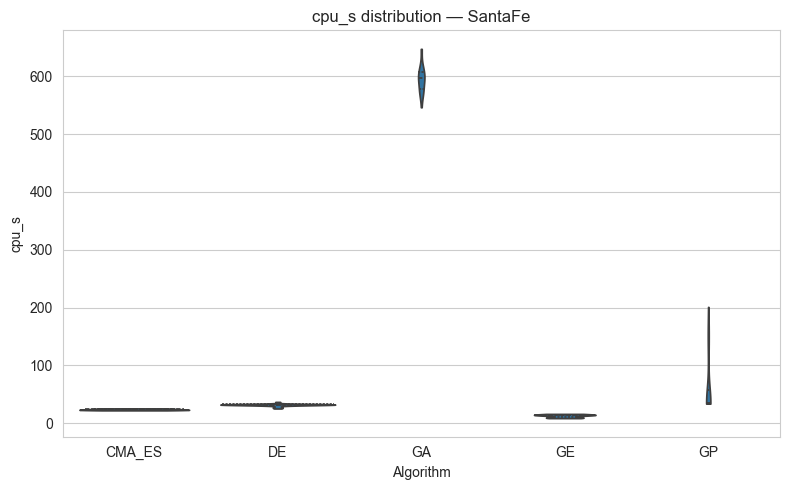

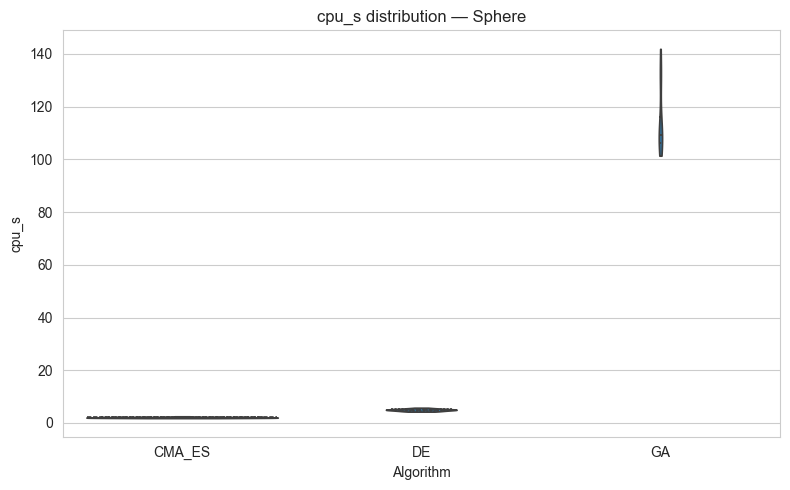

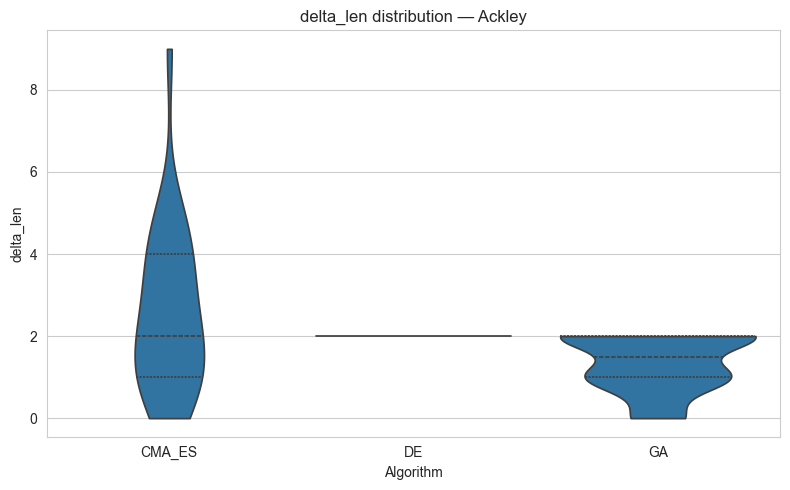

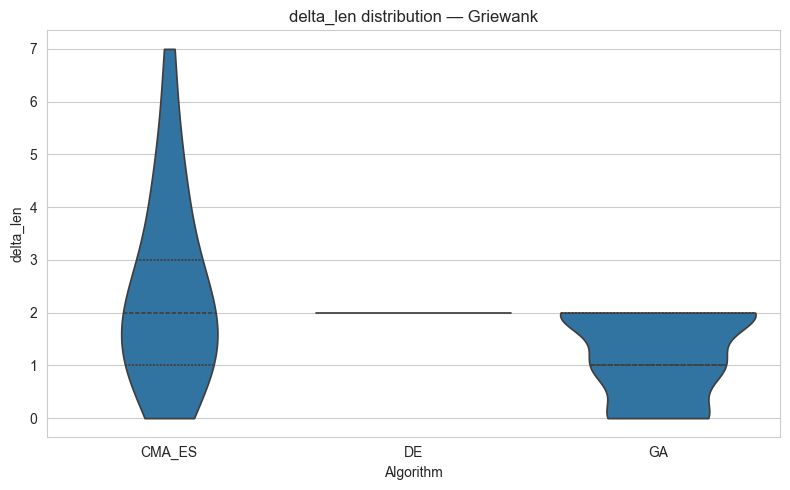

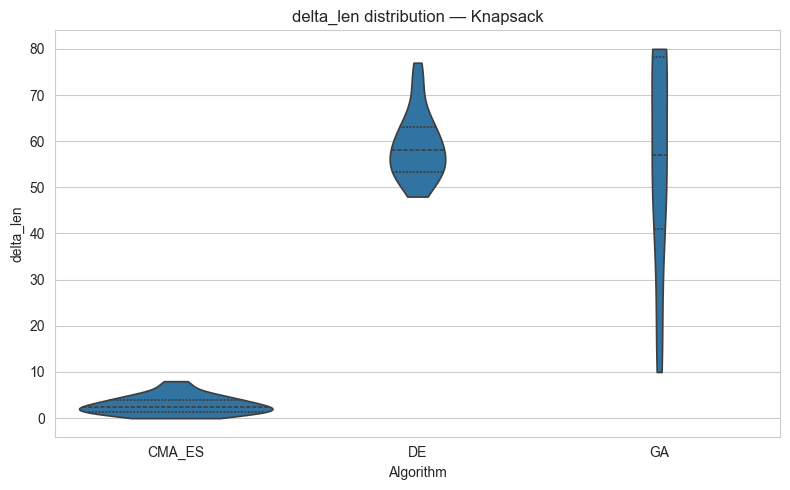

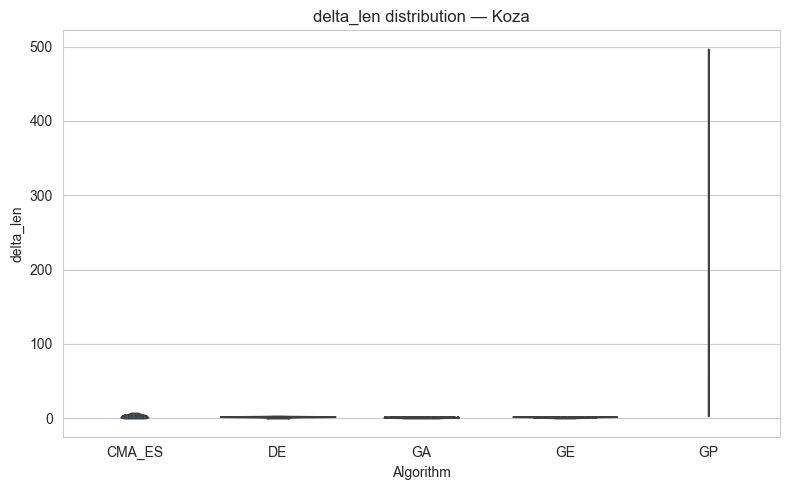

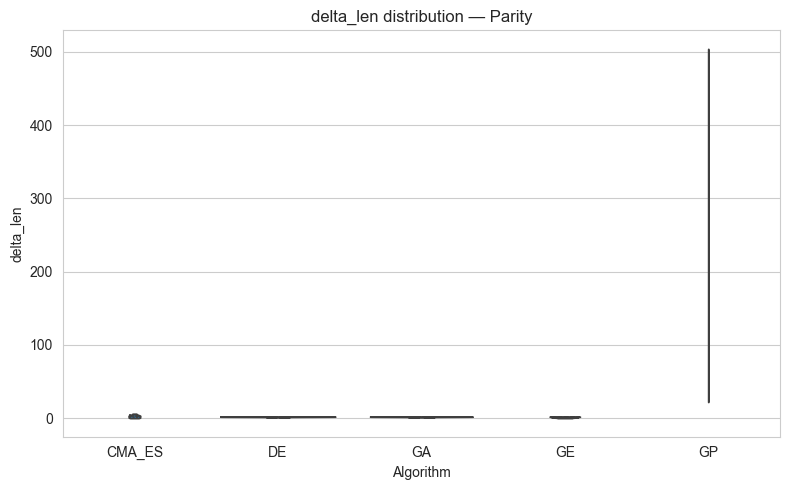

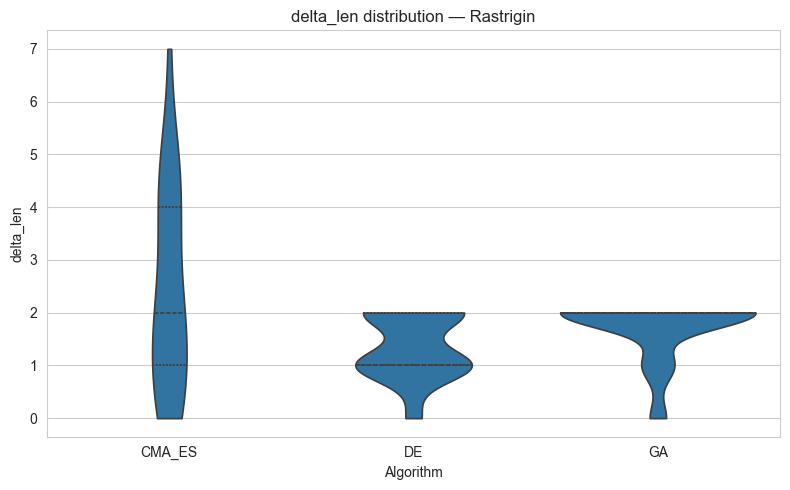

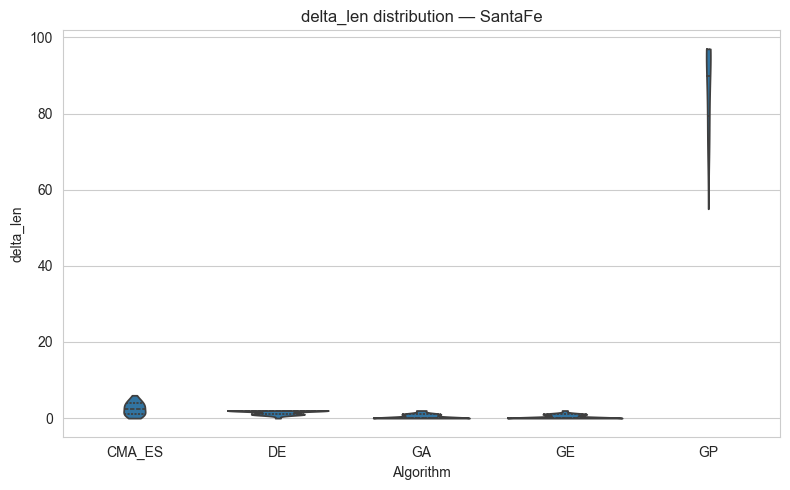

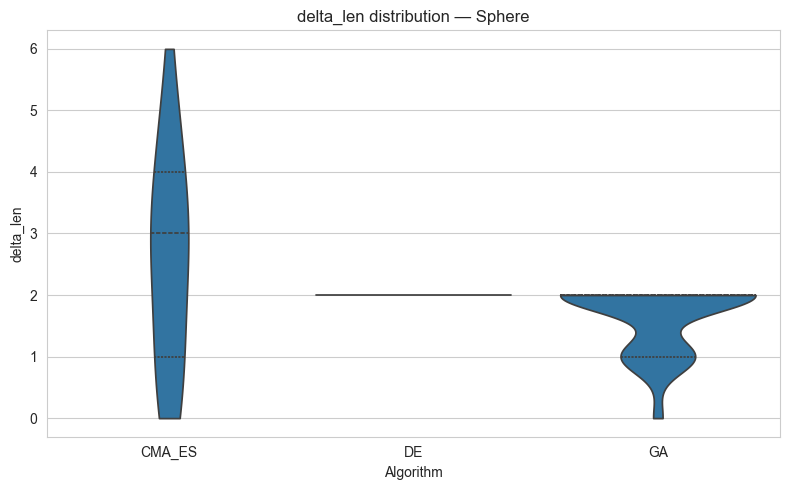

In [20]:
metrics = ['best','len_final','cpu_s','delta_len']
desc = results.groupby(['benchmark','algorithm'])[metrics].agg(
    ['mean','median','std',
     lambda x: x.quantile(0.25),
     lambda x: x.quantile(0.75)]
)
desc.columns = [
    f"{m}_{agg.__name__ if hasattr(agg,'__name__') else 'q'}"
    for m, agg in desc.columns
]
print(desc)

for m in metrics:
    for bench, sub in results.groupby('benchmark'):
        plt.figure(figsize=(8,5))
        sns.violinplot(x='algorithm', y=m, data=sub,
                       inner='quartile', cut=0)
        plt.title(f'{m} distribution — {bench}')
        plt.xlabel('Algorithm')
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

In [21]:
def friedmanPosthoc(df, metric):
    print(f'--- {metric} ---')
    for bench, sub in df.groupby('benchmark'):
        data = [g[metric].values for _, g in sub.groupby('algorithm')]
        stat, p = sstats.friedmanchisquare(*data)
        print(f'{bench}: Friedman stat={stat:.3f}, p={p:.3e}')
        if p < 0.05:
            pivot = sub.pivot(index='replicate',
                              columns='algorithm', values=metric)
            print(sp.posthoc_nemenyi_friedman(pivot))

for m in metrics:
    friedmanPosthoc(results, m)

--- best ---
Ackley: Friedman stat=27.800, p=9.190e-07
        CMA_ES        DE        GA
CMA_ES   1.000  0.001000  0.001000
DE       0.001  1.000000  0.477813
GA       0.001  0.477813  1.000000
Griewank: Friedman stat=22.467, p=1.323e-05
        CMA_ES        DE        GA
CMA_ES   1.000  0.001000  0.001000
DE       0.001  1.000000  0.774254
GA       0.001  0.774254  1.000000
Knapsack: Friedman stat=54.269, p=1.643e-12
          CMA_ES        DE     GA
CMA_ES  1.000000  0.008395  0.001
DE      0.008395  1.000000  0.001
GA      0.001000  0.001000  1.000
Koza: Friedman stat=88.853, p=2.307e-18
         CMA_ES     DE        GA        GE        GP
CMA_ES  1.00000  0.001  0.900000  0.001000  0.043750
DE      0.00100  1.000  0.001000  0.900000  0.001000
GA      0.90000  0.001  1.000000  0.001176  0.004081
GE      0.00100  0.900  0.001176  1.000000  0.001000
GP      0.04375  0.001  0.004081  0.001000  1.000000
Parity: Friedman stat=52.677, p=9.956e-11
         CMA_ES        DE        GA      

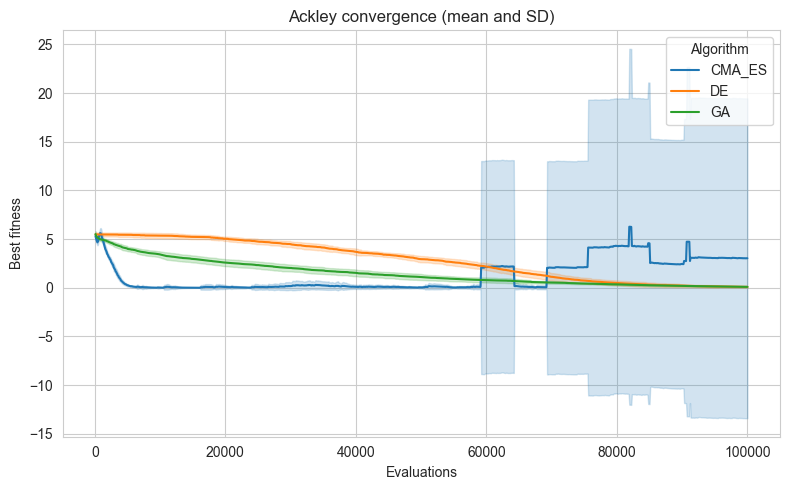

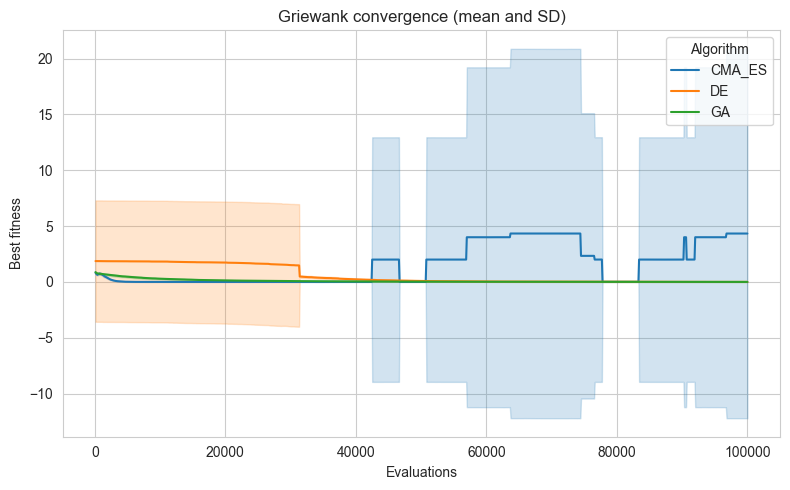

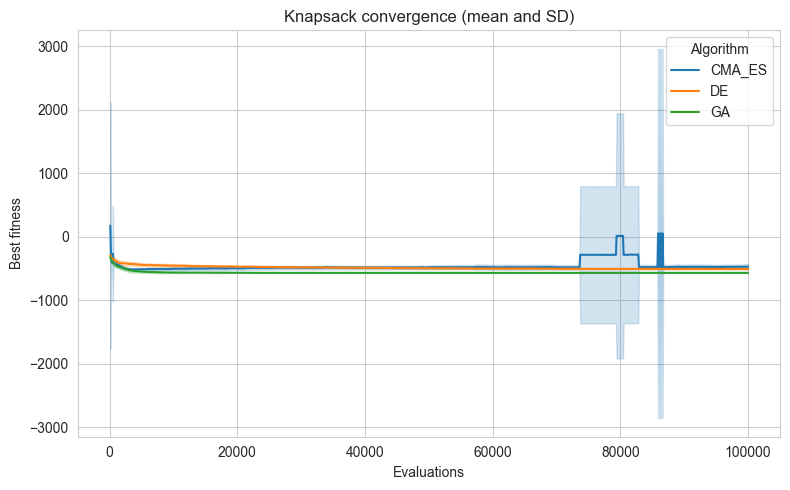

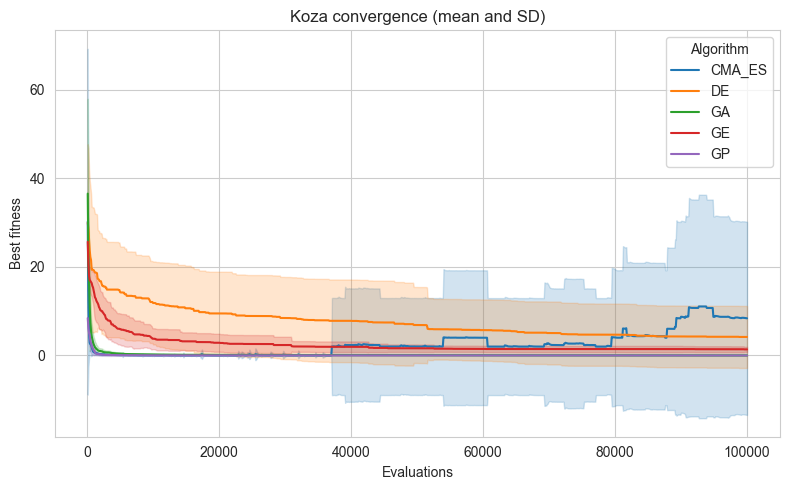

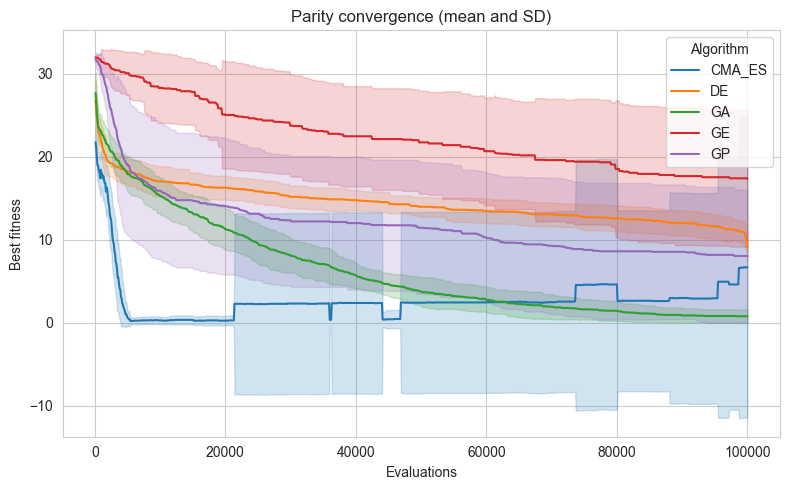

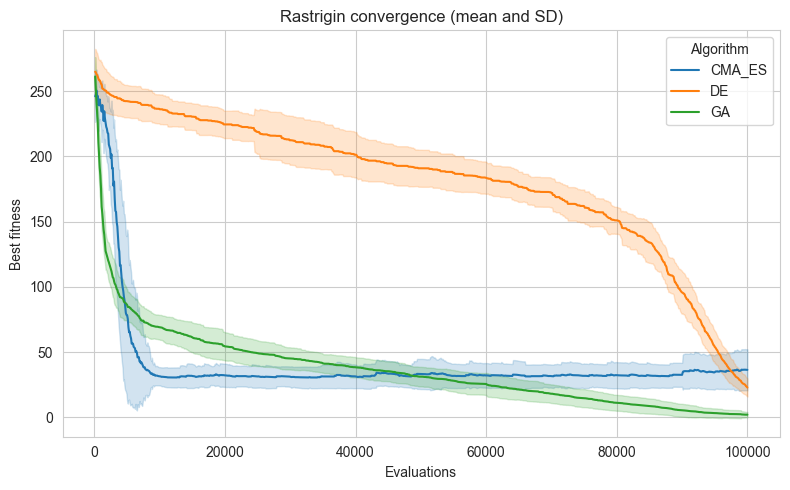

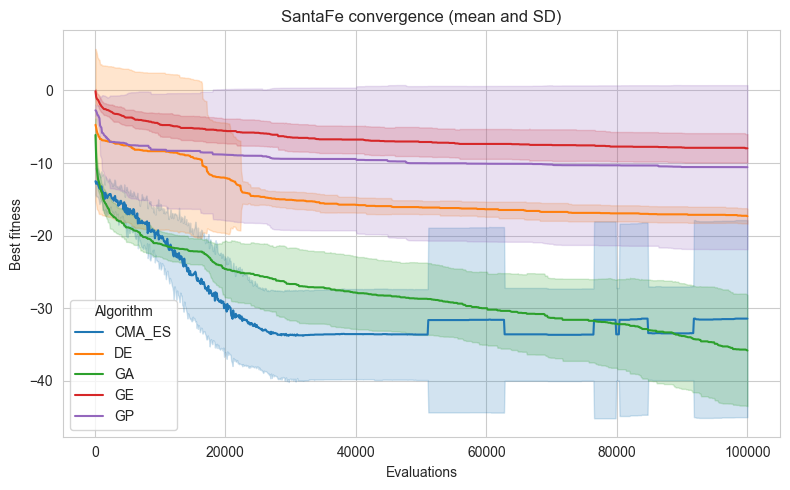

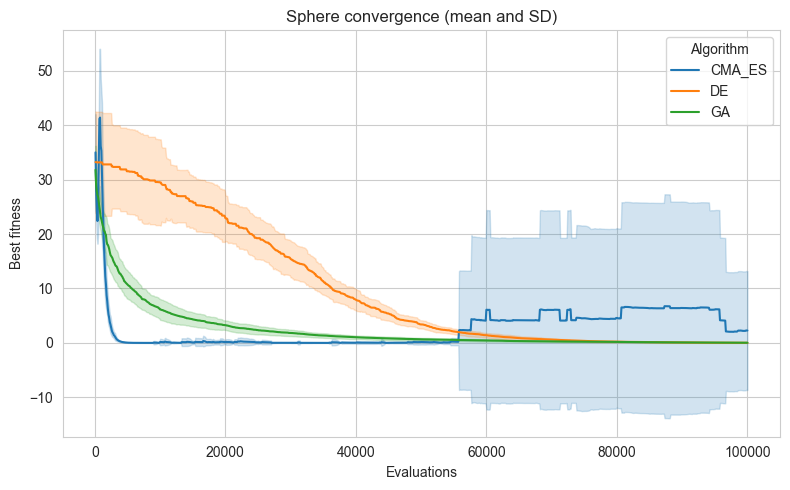

In [22]:
for bench, sub in history.groupby('benchmark'):
    plt.figure(figsize=(8,5))
    sns.lineplot(data=sub,
                 x='evals', y='fitness',
                 hue='algorithm',
                 estimator='mean', errorbar='sd')
    plt.title(f'{bench} convergence (mean and SD)')
    plt.xlabel('Evaluations')
    plt.ylabel('Best fitness')
    plt.legend(title='Algorithm')
    plt.tight_layout()
    plt.show()